In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [4]:
data = pd.read_csv("sonar data.csv", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [5]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [6]:
le = LabelEncoder()
y = le.fit_transform(y)

# R → 1, M → 0

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

Accuracy: 0.8333333333333334


In [13]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


Accuracy: 0.8571428571428571


In [17]:
gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3
)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_gb))


Accuracy: 0.8333333333333334


In [22]:
svm = SVC(kernel='rbf', C=10, gamma='scale')
svm.fit(X_train_scaled, y_train)

y_pred_svm = svm.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

Accuracy: 0.8809523809523809


In [23]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.001, 'scale'],
    'kernel': ['rbf']
}

grid = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='accuracy'
)

grid.fit(X_train_scaled, y_train)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.01, 0.001, 'scale'], 'kernel': ['rbf']},
             scoring='accuracy')

In [24]:
best_svm = grid.best_estimator_

y_pred_best = best_svm.predict(X_test_scaled)
print("Tuned SVM Accuracy:", accuracy_score(y_test, y_pred_best))


Tuned SVM Accuracy: 0.8809523809523809


In [25]:
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


[[21  1]
 [ 4 16]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89        22
           1       0.94      0.80      0.86        20

    accuracy                           0.88        42
   macro avg       0.89      0.88      0.88        42
weighted avg       0.89      0.88      0.88        42



In [26]:
cv_scores = cross_val_score(
    best_svm,
    X_train_scaled,
    y_train,
    cv=5
)

print("Cross-Validation Accuracy:", cv_scores.mean())


Cross-Validation Accuracy: 0.8675579322638146


In [31]:
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=grid.best_params_['C'],
                gamma=grid.best_params_['gamma']))
])

final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC(C=10))])

In [32]:
import pickle

pickle.dump(final_pipeline, open("sonar_model.pkl", "wb"))


In [34]:
acc_lr=0.8333333333333334
acc_svm=0.8809523809523809
acc_rf=0.8571428571428571
acc_gb=0.8333333333333334

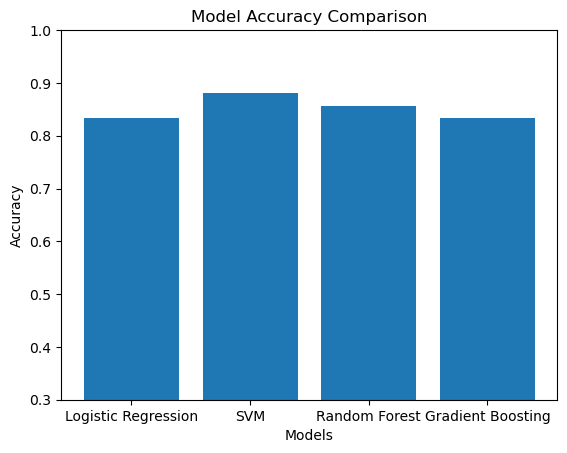

In [41]:
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'SVM', 'Random Forest', 'Gradient Boosting']
accuracies = [acc_lr, acc_svm, acc_rf, acc_gb] 

plt.figure()
plt.bar(models, accuracies)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0.3, 1.0)
plt.show()
